# Transfer Learning

There are variety of methodologies for transfer learning such as **fine tuning** and **frozen feature extraction**. In this tutorial, we will demonstrate how to do a **frozen feature extraction** transfer learning by using XenonPy.

This tutorial will use **Refractive Index** data which collected from [Polymer Genome](https://www.polymergenome.org). Due to permissions of Polymer Genome, we can't provide these data together with this tutorial. If you wan to rerun this notbook locally, you must collect these data yourself.

### useful functions

Run this cell will load some well-used packages such as `numpy`, `pandas`, and so on.
The running will also import some valuable functions which are written by ourselves.
There is no magic,  see `samples/tools.ipynb` to know what will be imported.

In [34]:
%run tools.ipynb

### frozen feature extraction

Do A frozen feature extraction transfer learing can be splitted into 2 steps.

1. you need per-trained model(s) as source. This can be done by accessing **XenonPy.MDL**. If you don't know how to do it, see https://xenonpy.readthedocs.io/en/latest/tutorials/5-pre-trained_model_library.html.

2. you need a feature extractor to generate new descriptors from the source model(s).
At here, we would like to intrduce you to our feature extractor, ``xenonpy.descriptor.FrozenFeaturizer``.

The following codes show a transfer learning from **Refractive Index** to **Refractive Index** but use different domian. The source models will are trained on the inorganic compounds data and the target is the same property in polymer.

Let's do this transfer learning step-by-setp.

#### 1. query **Refractive Index** models 

In [2]:
from xenonpy.mdl import MDL

mdl = MDL()
mdl

MDL(api_key='anonymous.user.key', endpoint='http://xenon.ism.ac.jp/api')

In [14]:
query = mdl(modelset_has="Stable", property_has="refractive")
query

QueryModelDetailsWith(api_key='anonymous.user.key', endpoint='http://xenon.ism.ac.jp/api', variables={'modelset_has': 'Stable', 'property_has': 'refractive'})
Queryable: 
 id
 transferred
 succeed
 isRegression
 deprecated
 modelset
 method
 property
 descriptor
 lang
 accuracy
 precision
 recall
 f1
 sensitivity
 prevalence
 specificity
 ppv
 npv
 meanAbsError
 maxAbsError
 meanSquareError
 rootMeanSquareError
 r2
 pValue
 spearmanCorr
 pearsonCorr

In [16]:
summary = query('id', 'modelset', 'meanAbsError', 'pearsonCorr').sort_values('meanAbsError')
summary.head(3)

,id,meanAbsError,modelset,pearsonCorr
311,2949,0.282434,Stable inorganic compounds in materials project,0.873065
847,4017,0.290382,Stable inorganic compounds in materials project,0.827995
1189,4702,0.293135,Stable inorganic compounds in materials project,0.876289


#### 2. download the best performance model based on MAE

In [55]:
results = mdl.pull(summary.id[0].item())
results

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


,id,model
0,2335,/Users/liuchang/projects/XenonPy/samples/inorg...


#### 3. load **Refractive Index** data from Polymer Genome and calculate the ``Composition`` descriptors

In [5]:
pg = <load your polyer genome data>

It shoud be organized as below.

In [26]:
pg.head(3)
pg.info()

,Smiles,Natoms,Ntypes,Volume of Cell($\AA^3$),"Band Gap, PBE(eV)","Band Gap, HSE06(eV)",Dielectric Constant,"Dielectric Constant, Electronic","Dielectric Constant, Ionic",Atomization Energy(eV/atom),Density(g/cm$^3$),Refractive Index,Ionization Energy(eV),Electron Affinity(eV),Cohesive Energy(eV/atom),composition,Formula
ID_name,,,,,,,,,,,,,,,,,
MOL1,[C@H]([CH]O)(O[C@H]1[C@H](CO)O[C@@H]([CH][C@@H...,84,3,572.42,5.62,7.48,3.78,2.85,0.93,-5.48,1.88,1.69,6.87,0.83,-0.63,"{'O': 20.0, 'H': 40.0, 'C': 24.0}",H40C24O20
MOL2,[CH][C@H](C[C@@H](C[C@H](C[CH][C]=[CH])C(=[CH]...,128,2,1258.30,3.94,4.83,2.72,2.64,0.08,-5.90,1.10,1.62,3.56,1.56,-0.63,"{'C': 64.0, 'H': 64.0}",H64C64
MOL3,C[C@H](C[CH][CH][CH]C)[CH2].C[C@@H](C[CH][CH][...,108,2,762.10,6.32,7.70,2.61,2.59,0.02,-5.14,1.10,1.61,6.19,0.43,-0.51,"{'C': 36.0, 'H': 72.0}",H72C36


<class 'pandas.core.frame.DataFrame'>
Index: 1069 entries, MOL1 to MOL1069
Data columns (total 17 columns):
Smiles                             1069 non-null object
Natoms                             1069 non-null int64
Ntypes                             1069 non-null int64
Volume of Cell($\AA^3$)            1069 non-null float64
Band Gap, PBE(eV)                  1069 non-null float64
Band Gap, HSE06(eV)                1069 non-null float64
Dielectric Constant                1069 non-null float64
Dielectric Constant, Electronic    1069 non-null float64
Dielectric Constant, Ionic         1069 non-null float64
Atomization Energy(eV/atom)        1069 non-null float64
Density(g/cm$^3$)                  344 non-null float64
Refractive Index                   1069 non-null float64
Ionization Energy(eV)              330 non-null float64
Electron Affinity(eV)              330 non-null float64
Cohesive Energy(eV/atom)           344 non-null float64
composition                        1069 non-nu

In [27]:
from xenonpy.descriptor import Compositions

pg_desc = Compositions().transform(pg['composition'])
pg_desc.head(3)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
ID_name,,,,,,,,,,,,,,,,,,,,,
MOL1,4.095238,98.42891,168.333333,11.561905,7.721000,1488.27381,54.596505,20.761905,51.333333,51.666667,...,1.0,1.0,0.711,0.02658,110.0,120.0,162.0,288.6,317.5,0.666793
MOL2,3.500000,85.00000,172.000000,9.700000,6.509500,2560.14000,44.899820,27.205000,52.000000,53.500000,...,1.0,1.0,0.711,0.18050,110.0,120.0,162.0,288.6,1270.0,0.666793
MOL3,2.666667,83.00000,166.000000,11.166667,4.675667,1713.52000,48.866426,20.306667,45.000000,46.333333,...,1.0,1.0,0.711,0.18050,110.0,120.0,162.0,288.6,1270.0,0.666793


#### 4. predict Polymer Genomer **Refractive Index** form a inorganic model directly

In [32]:
from xenonpy.model.training import Checker

checker = Checker(results.model[0])
checker.checkpoints

<Checker> includes:
"mse_3": /Users/liuchang/projects/XenonPy/samples/inorganic.crystal.refractive_index/xenonpy.compositions/pytorch.nn.neural_network/290-96-55-52-1-$smDZGPzSd/checkpoints/mse_3.pth.s
"mse_1": /Users/liuchang/projects/XenonPy/samples/inorganic.crystal.refractive_index/xenonpy.compositions/pytorch.nn.neural_network/290-96-55-52-1-$smDZGPzSd/checkpoints/mse_1.pth.s
"mae_2": /Users/liuchang/projects/XenonPy/samples/inorganic.crystal.refractive_index/xenonpy.compositions/pytorch.nn.neural_network/290-96-55-52-1-$smDZGPzSd/checkpoints/mae_2.pth.s
"r2_5": /Users/liuchang/projects/XenonPy/samples/inorganic.crystal.refractive_index/xenonpy.compositions/pytorch.nn.neural_network/290-96-55-52-1-$smDZGPzSd/checkpoints/r2_5.pth.s
"mse_5": /Users/liuchang/projects/XenonPy/samples/inorganic.crystal.refractive_index/xenonpy.compositions/pytorch.nn.neural_network/290-96-55-52-1-$smDZGPzSd/checkpoints/mse_5.pth.s
"r2_1": /Users/liuchang/projects/XenonPy/samples/inorganic.crystal.refra

In [81]:
# --- pre-trained model for prediction
from xenonpy.model.training import Trainer

trainer = Trainer.load(from_=checker)
trainer.reset(to='r2_1')
trainer

Trainer(clip_grad=None, cuda=None, epochs=200, loss_func=None,
        lr_scheduler=None,
        model=SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=96, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(96, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in...
    (normalizer): BatchNorm1d(55, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=55, out_features=52, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(52, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=52, out_features=1, bias=True)
),
        non_blocking=False, optimizer=None)

Missing directory and/or file name information!


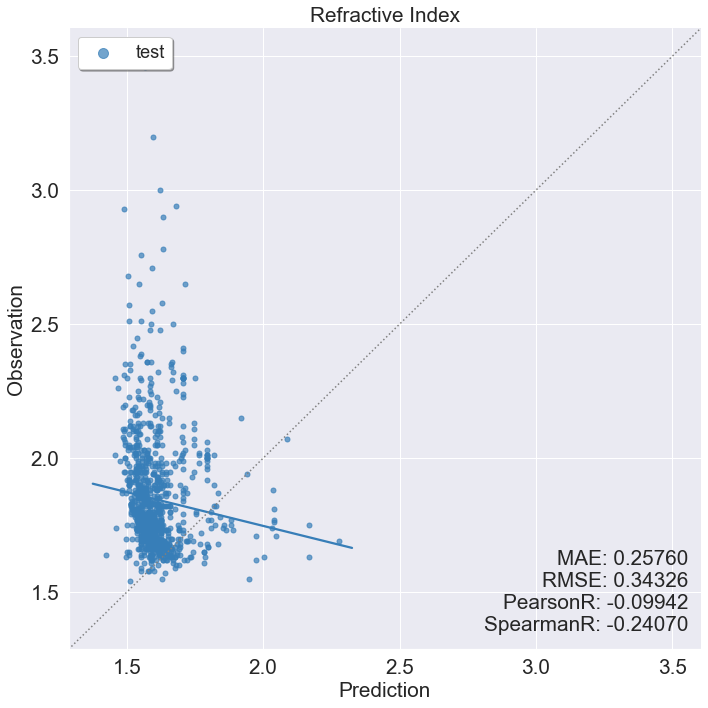

In [82]:
y_pred = trainer.predict(x_in=torch.tensor(pg_desc.values, dtype=torch.float)).detach().numpy().flatten()
y_true = pg['Refractive Index'].values

draw(y_true, y_pred, prop_name='Refractive Index')

#### 5. frozen feature extraction

``FrozenFeaturizer`` accept a [Pytorch](https://pytorch.org) model as its input.

In [83]:
# --- import necessary libraries

from xenonpy.descriptor import FrozenFeaturizer

# --- init FrozenFeaturizer with NN model
ff = FrozenFeaturizer(model=trainer.model)
ff

FrozenFeaturizer(cuda=False, depth=None,
                 model=SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=290, out_features=96, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(96, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=96, out_features=55, bias=True...
    (normalizer): BatchNorm1d(55, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=55, out_features=52, bias=True)
    (dropout): Dropout(p=0.1)
    (normalizer): BatchNorm1d(52, eps=0.1, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=52, out_features=1, bias=True)
),
                 on_errors='raise', return_type='any')

The following code will generate new descriptors

In [84]:
neural_descriptors = ff.transform(pg_desc, depth=2 ,return_type='df')

Here, ``depth=1`` means only the last hidden layer will be used as descriptor calculator.

In [85]:
neural_descriptors.head(3)

,L(-2)_1,L(-2)_2,L(-2)_3,L(-2)_4,L(-2)_5,L(-2)_6,L(-2)_7,L(-2)_8,L(-2)_9,L(-2)_10,...,L(-1)_43,L(-1)_44,L(-1)_45,L(-1)_46,L(-1)_47,L(-1)_48,L(-1)_49,L(-1)_50,L(-1)_51,L(-1)_52
ID_name,,,,,,,,,,,,,,,,,,,,,
MOL1,-1.944200,-1.912182,0.874970,0.815631,0.548256,-3.550575,5.558849,0.714539,-1.386736,-4.649428,...,-1.475150,0.592037,-1.109088,-0.647387,-1.340191,0.504055,-0.346854,-1.455786,-1.970067,-2.001308
MOL2,-2.376811,-2.007954,1.445591,1.449255,0.854345,-3.600459,6.511922,0.863193,-1.627964,-4.860580,...,-1.763694,0.806165,-1.406876,-0.801517,-1.835923,0.580723,-0.459899,-1.811590,-2.612121,-2.544362
MOL3,-2.069772,-1.931271,0.975399,0.970109,0.606790,-3.514987,5.725475,0.717368,-1.432448,-4.653154,...,-1.521431,0.626859,-1.149925,-0.676541,-1.424905,0.515915,-0.363829,-1.506981,-2.078453,-2.081555


**-1** in the column names denote the last layer.

In [86]:
# --- import necessary libraries

from xenonpy.visualization import DescriptorHeatmap

DescriptorHeatmap(bc=True, col_cluster=True, col_colors=None, col_linkage=None,
                  figsize=(70, 10), mask=None, method='average',
                  metric='euclidean', pivot_kws=None, row_cluster=False,
                  row_colors=None, row_linkage=None, save=None)

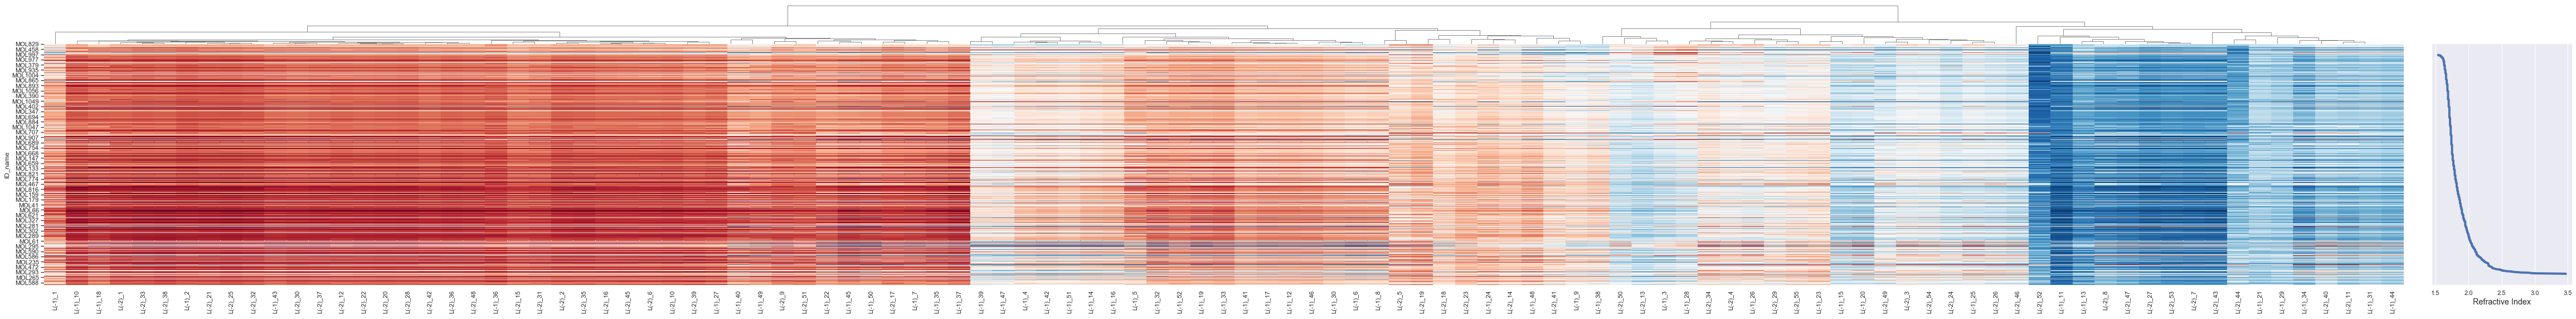

In [87]:
sorted_prop = pg['Refractive Index'].sort_values()
sorted_desc = neural_descriptors.loc[sorted_prop.index]

heatmap = DescriptorHeatmap( 
        bc=True,  # use box-cox transform 
#         save=dict(fname='heatmap_density', dpi=150, bbox_inches='tight'),  # save fingure to file
        figsize=(70, 10))
heatmap.fit(sorted_desc)
heatmap.draw(sorted_prop)

#### 6. use neural descriptors to train new models.

In this case **Random Forest** model and **Bayesian Ridge Linear** model will be trained.

In [88]:
# split data
from xenonpy.datatools import Splitter

y = pg['Refractive Index']
splitter = Splitter(len(y), test_size=0.2)

X_train, X_test, y_train, y_test = splitter.split(neural_descriptors, y.values.reshape(-1, 1))

In [89]:
# random forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train.ravel())
y_pred = rf.predict(X_test)
y_fit_pred = rf.predict(X_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Missing directory and/or file name information!


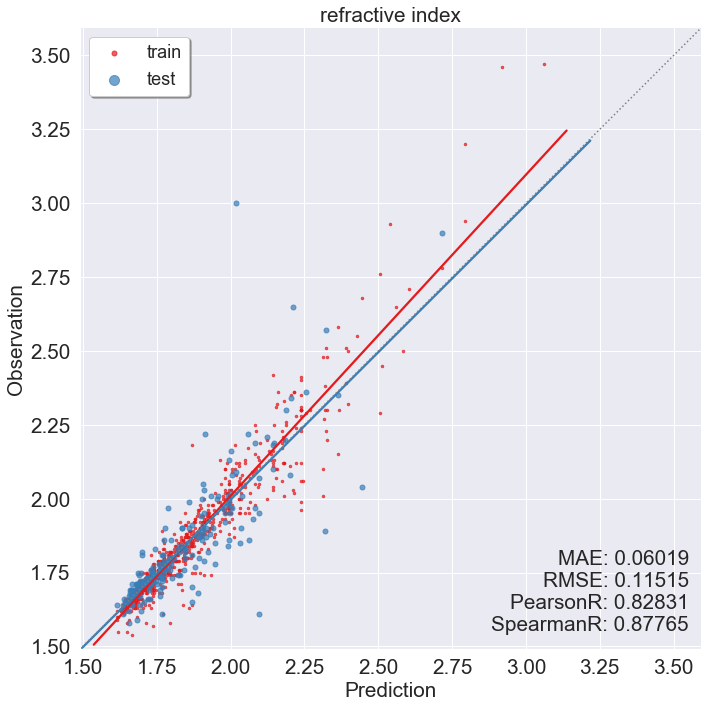

In [90]:
draw(y_test.ravel(), y_pred, y_train.ravel(), y_fit_pred, prop_name='refractive index')

In [91]:
# bayesian linear
from sklearn.linear_model import BayesianRidge

br = BayesianRidge()
br.fit(X_train, y_train.ravel())
y_pred = br.predict(X_test)
y_fit_pred = br.predict(X_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

Missing directory and/or file name information!


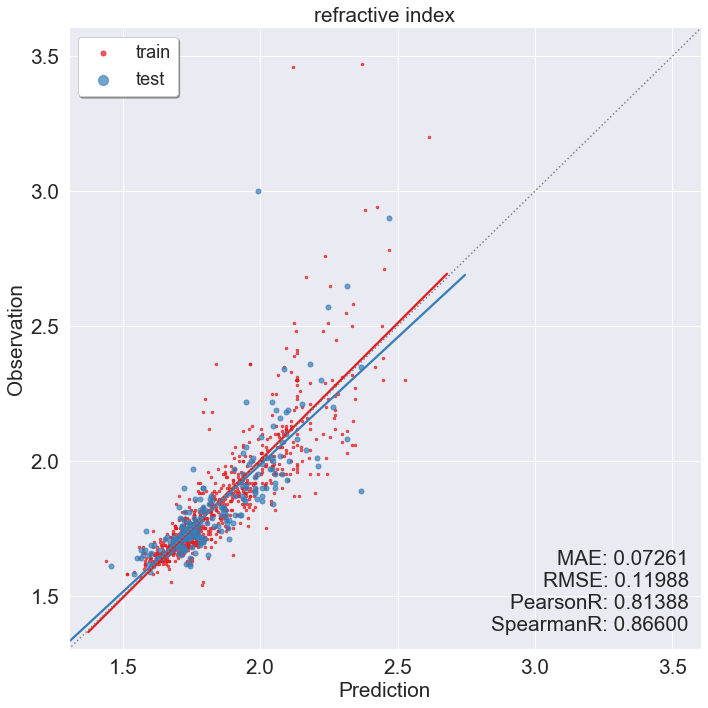

In [92]:
draw(y_test.ravel(), y_pred, y_train.ravel(), y_fit_pred, prop_name='refractive index')